<a href="https://colab.research.google.com/github/basakesin/MAST-Rhythm-Automatic-Assessment/blob/master/MASTRhythm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the code to perform all the analysis steps described in paper: "....". Running the cells, you can reproduce all results in the paper. If you use this code in your research please cite the paper above.

Some of the functions (marked as '@author: felipevieira') are copied from the two following notebooks:
https://github.com/MTG/mast-rhythm-analysis/blob/master/notebooks/BaselineRhythmicAssessmentSystem.ipynb
https://github.com/MTG/mast-rhythm-analysis/blob/master/notebooks/PreProcessDataFromMASTDataset.ipynb
some of which are edited versions of Essentia library tutorials available here:  https://essentia.upf.edu/essentia_python_tutorial.html

# **Install requirements and import libraries**

In [1]:
"""
@author: basakesin, barisbozkurt, felipevieira
"""
#Install requirements
!pip3 install essentia resampy wavio textdistance

#Load required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, Onsets, FrameGenerator, Spectrum, Energy
from essentia import Pool, array
from sklearn.metrics import mean_absolute_error,  mean_squared_error
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from scipy import spatial, stats
import resampy
import wavio
from numpy import sort

     |████████████████████████████████| 11.7MB 3.3MB/s 


# **Download MAST-rhythm dataset**

In [2]:
"""
@author: felipevieira
https://github.com/MTG/mast-rhythm-analysis/blob/master/notebooks/DownloadDataFromMASTDataset.ipynb
"""
import urllib.request
import os
import tarfile

FILES = {
    'https://www.dropbox.com/s/54w5ohm9rh9q9cb/MAST%20subset%20%5BReferences%5D.tar.xz?dl=1' : 'MAST subset [References].tar.xz',
    'https://www.dropbox.com/s/rinjhw4gb5mj286/MAST%20subset%20%5BPerformances%5D.tar.xz?dl=1' : 'MAST subset [Performances].tar.xz',
    'https://www.dropbox.com/s/yzvicftsjt6rr8w/Performances%20Annotations.tar.xz?dl=1' : 'Performances Annotations.tar.gz',
    'https://www.dropbox.com/s/zrtznm51ddtvwcr/rhy_m4a.tar.xz?dl=1': 'rhy_m4a.tar.xz'
}

DATA_FOLDER = "data/"

if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for file_url in FILES.keys():
    file_name = FILES[file_url]
    
    print("Downloading file %s" %  file_name)
    
    # downloading file
    urllib.request.urlretrieve(file_url, os.path.join(DATA_FOLDER, file_name))
    
    # extracting file
    tar = tarfile.open(os.path.join(DATA_FOLDER, file_name))
    tar.extractall(DATA_FOLDER)
    tar.close()
    os.remove(os.path.join(DATA_FOLDER, file_name))
  
print()
print("All folders and files were downloaded and stored in %s" % DATA_FOLDER)
    


All folders and files were downloaded and stored in data/


# **Feature extraction**

## Setting analysis parameters

In [0]:
#Define data folder and default parameters
DATA_FOLDER = "data/"

# audio loading parameters
SAMPLE_RATE = 44100
WINDOW_SIZE = 1024
HOP_SIZE = 512
WINDOWING_METHOD = 'hann'

# onset detection parameters
ONSET_DETECTION_METHOD = 'hfc' #BB: bunu bir loop'ta belirlemiyor ve çeşitli ODFleri test etmiyor muyduk?

# used for quantizing purposes
ONSET_N_OF_BINS = 60


The features used in our task are the distances computed between performance and reference. Two strategies are tested

*   Distances computed between onsets of reference and performance
*   Distance computed between onset detection functions of reference and performance

Below, we provide the codes for:

*   Computing onset detection function
*   Computing onsets
*   Computing distances between onset detection functions
*   Computing distances between onsets



## Onset detection function computation

In [0]:
def spectral_flux(x, WINDOW_SIZE, winType = "hann"):
    '''
    Calculates the spectral flux of a record

    Parameters
    ----------
    x : numpy.array
       The record signal
       
    WINDOW_SIZE : integer
       Window size to calculate spectrum of the record
       
    winType : string
        Windowing method, default = 'hann'
        
    Returns
    -------
    SF : numpy.array
        Spectral flux of the record
    '''
    w = Windowing(type = winType)
    spectrum = Spectrum(size = WINDOW_SIZE)

    prevAmpSpec = np.zeros((1 + int(WINDOW_SIZE / 2),))
    sf = []
    for frame in FrameGenerator(x, frameSize = WINDOW_SIZE):
        ampSpec = spectrum(w(frame))
        specDiff = ampSpec - prevAmpSpec
        h = (specDiff + np.abs(specDiff)) / 2
        sf.append(np.sum(h))
        prevAmpSpec = ampSpec
    SF = np.array(sf[1:])#discard the first dummy value
    return SF

def highFreqCont(x, WINDOW_SIZE, winType = "hann"):
    '''
    Calculates the high frequency content of a record

    Parameters
    ----------
    x : numpy.array
       The record signal
       
    WINDOW_SIZE : integer
       Window size to calculate spectrum of the record
       
    winType : string
        Windowing method, default = 'hann'
        
    Returns
    -------
    hfc : numpy.array
        High frequency content of the record
    '''
    w = Windowing(type = winType)
    spectrum = Spectrum(size = WINDOW_SIZE)

    hfc = []
    for frame in FrameGenerator(x, frameSize = WINDOW_SIZE):
        ampSpec = spectrum(w(frame))
        hfc.append(np.dot(np.power(ampSpec,2),np.arange(ampSpec.size)))
    hfc = np.array(hfc)
    return hfc

def energy_deviation(x, WINDOW_SIZE, winType = "hann"):
    '''
    Calculates the energy deviation of a record

    Parameters
    ----------
    x : numpy.array
       The record signal
       
    WINDOW_SIZE : integer
       Window size to calculate spectrum of the record
       
    winType : string
        Windowing method, default = 'hann'
        
    Returns
    -------
    NRG_dev : numpy.array
        Energy deviation of the record
    '''
    w = Windowing(type = winType)
    energy = Energy()
    NRG = []
    for frame in FrameGenerator(x, frameSize = WINDOW_SIZE):
        NRG.append(np.log10(energy(w(frame))+np.finfo(float).eps))
    NRG = np.array(NRG)
    NRG_dev = NRG[1:] - NRG[:-1]

    return NRG_dev



## Onset detection

The functions defined below find the onset locations and create 60 bins between the first and last onsets of each record to satisfy the time alignment.

In [0]:
def extract_onsets(base_dir, list_files, output_file):
    '''
    Extract the onset vectors of the records that are listed in list_files and write them the respective output_file

    Parameters
    ----------
    base_dir: string
       The folder path that contains the audio files 
    
    list_files: string
       The path of the text file that contains the audio file names 

    output_file: string
        The path of the output file
        
    Returns
    -------
    Fills the output_file

    @author: felipevieira
    '''
    with open(list_files, 'r') as listfiles:
        with open(output_file, 'w') as output:
            for audio_file in listfiles.readlines():
                audio_file = audio_file.strip()
                audio_file_full_path = os.path.join(base_dir, audio_file)

                w = _load_file_as_monophonic_waveform(audio_file_full_path)
                onsets = _extract_onset_vectors(w)
                
                output.write('%s\n' % " ".join(list(str(x) for x in onsets)))

def _extract_onset_vectors(waveform):
    '''
    Extract the onset vectors from the waveform

    Parameters
    ----------
    waveform: numpy.array
       The waveform of the audio record

    Returns
    -------
    onsets : numpy.array
        Onsets vector for the waveform

    Slightly modified version of: https://github.com/MTG/essentia/blob/master/src/examples/tutorial/example_onsetdetection.py
    '''
    od = OnsetDetection(method=ONSET_DETECTION_METHOD)
    w = Windowing(type=WINDOWING_METHOD)
    fft = FFT()
    c2p = CartesianToPolar()
    onsets = Onsets()

    pool = Pool()
    for frame in FrameGenerator(waveform, frameSize=WINDOW_SIZE):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features', od(mag, phase))

    onsets = onsets(array([pool['features']]),[1])
    return onsets


In [0]:
def rescale_and_make_bins(performances_file, references_file):
    '''
    Creates text file that contains binary arrays related with bins for each record whether a bin contains onset or not

    Parameters
    ----------

    performances_file : string
        Path of the text file contains performance onset vectors created by extract_onsets function

    references_file : string  
        Path of the text file contains reference onset vectors created by extract_onsets function

    Returns
    -------
   
    Create a text file that contains binary arrays whether a performance or reference record contains onset at that bin or not.

    @author: felipevieira
    '''
    with open(performances_file, 'r') as perf_onsets_file:
        with open(references_file, 'r') as ref_onsets_file:
            perfs_onsets = perf_onsets_file.readlines()
            refs_onsets = ref_onsets_file.readlines()
            with open('%s [BINS]' % performances_file, 'w') as performances_file_bin,\
                 open('%s [BINS]' % references_file, 'w') as references_file_bin:
                for i in range(len(perfs_onsets)):
                    perf_onsets = [ float(x) for x in perfs_onsets[i].strip().split(" ") ]

                    perf_first_onset = perf_onsets[0]
                    perf_last_onset = perf_onsets[-1]
                    
                    ref_onsets = [ float(x) for x in refs_onsets[i].strip().split(" ") ]
                    ref_first_onset = ref_onsets[0]
                    ref_last_onset = ref_onsets[-1]                  

                    # setting onset boundaries from first to last onsets
                    perf_onsets = [ x - perf_onsets[0] for x in perf_onsets ]                   
                    ref_onsets = [ x - ref_onsets[0] for x in ref_onsets ]
                    

                    # re-scaling performance to match reference tempo
                    perf_inner_duration = perf_onsets[-1] - perf_onsets[0]
                    ref_inner_duration = ref_onsets[-1] - ref_onsets[0]   
                    
           
                    time_rescaling_factor = ((perf_inner_duration - ref_inner_duration) / perf_inner_duration)
                    
                    # onset window size is defined as a function of the audio duration
                    window_size = ref_inner_duration / ONSET_N_OF_BINS
                    

                    rescaled_perf_onsets = [adjust_onset_by_rate(onset, time_rescaling_factor) for onset in perf_onsets]
           
                    performance_onset_bins = make_bins(rescaled_perf_onsets, window_size)
                    performances_file_bin.write('%s\n' % " ".join([str(x) for x in performance_onset_bins]))
                    references_onset_bins = make_bins(ref_onsets, window_size)
                    references_file_bin.write('%s\n' % " ".join([str(x) for x in references_onset_bins]))


def make_bins(onset_times, window_size):
    '''
    Generate an binary array whether a bin contains onset or not.

    Parameters
    ----------

    onset_times : np.array
        Onset times

    window_size : integer 
        Window size

    Returns
    -------
   
    bins : np.array
    
      Array with binary numbers each related whether a window has onset or not.
 
    @author: felipevieira
    '''
    bins = []
        
    for i in range(int(ONSET_N_OF_BINS)):
        for onset_time in onset_times:
            if i == ONSET_N_OF_BINS-1:
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + float('inf')):
                    bins.append(1)
                    break
                else:
                    continue
            else:                
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + 0.5):
                    bins.append(1)
                    break
        else:
            bins.append(0)

    return bins

def adjust_onset_by_rate(onset, time_rescaling_factor):
    '''@author: felipevieira'''
    return onset - (onset * time_rescaling_factor)



## Computing distances between onset detection functions

####Compute distances between binary onset vectors

In [7]:
from sklearn.datasets.base import *
from textdistance import levenshtein, damerau_levenshtein, jaro, jaro_winkler
from scipy.spatial.distance import yule, matching, hamming

def mean_squared_error_for_rhythm(A_bin, E_bin, Km = 25 , Ks = 0.55):
    '''
    Implementation of a MSE function designed
    for rhythmic assessment purposes. The original
    algorithm is proposed by Percival in
    http://percival-music.ca/research/masters-percival.pdf
    
    @author: felipevieira
    '''
    def closest_value(alist, value):
        min_diff = float('inf')
        c_value = None
        
        for element in alist:
            if abs(value - element) < min_diff:
                min_diff = abs(value - element)
                c_value = element
        
        return c_value
                
        
    A = [i for i in range(len(A_bin)) if A_bin[i]]
    E = [i for i in range(len(E_bin)) if E_bin[i]]
    
    mse = 0
    
    for i in range(len(E)):
        c_val = closest_value(A, E[i])
        error = abs(c_val - E[i])
        error = np.power(error,2)/len(E)
        error = min(error, Km)
        mse+=error
    
    for i in range(len(A)):
        c_val = closest_value(E, A[i])
        error = abs(c_val - A[i])
        error = np.power(error,2)/len(A)
        error = min(error, Km)
        mse+=error
    
    return 100 - Ks * mse

def beat_difference(v1, v2):
    '''
    Calculates the beat_difference between two vectors

    Parameters
    ----------
    v1: numpy.array
       First vector (eg. reference onsets)
    v2: numpy.array
      Second vector (eg. performance onsets)
        
    Returns
    -------
    onsets : numpy.array
        Onsets vector for the waveform

    @author: felipevieira
    '''
    return abs(v1.count(1) - v2.count(1))

DISTANCE_FUNCTIONS = [beat_difference, mean_squared_error_for_rhythm, #rhythm-based features
                          levenshtein, damerau_levenshtein, jaro, jaro_winkler, # text-based features
                          hamming, yule] # vector-based features

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


####Compute distances between onset detection functions

In [0]:
#Distance functions applied on onset detection functions:
# L1-norm, L2-norm, cosine-distance, earth-mover distance, max-distance
def calculate_distance_features(x_references, x_performances):
    '''
    Calculate the distance between reference and performance data with different distance metrics

    Parameters
    ----------
    x_reference : numpy.array 
        Reference data that contains spectral flux, high frequency content and energy deviation.
        
    x_performance : numpy.array 
        Performance data that contains spectral flux, high frequency content and energy deviation.


    Returns
    -------
    distance_features : numpy.array
        distance between reference and performance data with different distance metrics

    '''
    if(x_performances.shape[0] != x_references.shape[0]):
        print("x_performance and x_reference must be same size")
    else:
        dist = np.empty((x_performances.shape[0],5))
        
        for i in range(x_performances.shape[0]):
            dist[i,0] = np.max(x_references[i,:]-x_performances[i,:]) #maximum difference
            dist[i,1] = np.linalg.norm((x_references[i,:]-x_performances[i,:]), ord=1)  #L1 norm
            dist[i,2] = np.linalg.norm((x_references[i,:]-x_performances[i,:])) #L2 norm
            dist[i,3] = spatial.distance.cosine(x_references[i,:],x_performances[i,:]) #cosine similarity
            dist[i,4] = stats.wasserstein_distance(x_references[i,:],x_performances[i,:])/len(x_performances) #earth mover distance
        distance_features = dist
    return distance_features

# **Data preparation: batch processing of audio files**

#### Data Preparation

In [0]:
def _load_file_as_monophonic_waveform(file_path):
    '''
    Load the audio file as monophonic waveform from the file path

    Parameters
    ----------
    file_path : string
      The path of the audio file

    Returns
    -------
    normalized_x : numpy.array
        normalized waveform of the audio record
    
    @author: felipevieira

    '''
    fs = SAMPLE_RATE

    x = MonoLoader(filename = file_path, sampleRate = fs)()
    normalized_x = x / np.max(np.abs(x))
    return normalized_x

def get_audio_index(file, performance_type):
    '''
    Gets audio index

    Parameters
    ----------
    file : string
       The name of the audio file 
    
    performance_type : string
       Describes the performance type "performance" (student performance) or "reference" (jury member performance)


    Returns
    -------
    audio_idx : integer
        Index of the audio file
    
    @author: felipevieira
    '''
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        audio_idx = files.index(file)
        return audio_idx
    
def get_info(index, performance_type, info_file_format):   
    '''
    Gets audio index

    Parameters
    ----------
    index : integer
       Index of the audio file
    
    performance_type : string
       Describes the performance type "performance" (student performance) or "reference" (jury member performance)

    info_file_format : string
        Name of the file that contains features
        
    # Returns
    # -------
    # audio_idx : integer
    #     Index of the audio file

    @author: felipevieira
    '''
    
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]

def get_class_for_performance(audio_name):
    '''
    Gets audio index

    Parameters
    ----------
    audio_name : string
       The name of the audio file 
    
    Returns
    -------
    annotations : numpy.array
        The matrix that contains grades of each jury member for each performances. 

    @author: felipevieira
    '''
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                
    return annotations


In [0]:
def load_onsetDistances_labels():
    '''
    Function renamed from "load_rhythmic_performances" to 
    Loads rhytmic performances and extract onset based distance features and target labels

    Returns
    -------
    features : numpy.array
        Onset based distance feature matrix that contains each feature in its columns.
        
    annotations : numpy.array
        The matrix that contains grades of each jury member for each performances. 

    @author: felipevieira
    '''
    features = []
    annotations = np.zeros((80,7))
    i = 0
    with open('data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('data/Only Performances/listperformances', 'r') as performances_file,\
         open('data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('data/Only References/listreferences', 'r') as references_file,\
         open('data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')   
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            annotations[i,:] = get_class_for_performance(performance)
            i = i+1
    return np.array(features), annotations



def calculate_average_grade(annotations):
    '''
    Calculate average grades by dropping minimum and maximum grades for each performance

    Parameters
    ----------

    annotations : numpy.array
        The matrix that contains grades of each jury member for each performances. 

    Returns
    -------
   
    average_grade : numpy.array
        The average grades of each performance

    @author: felipevieira
    '''
  # the average grade across all annotations is calculated according to the following:
  # "leave the max and min value out and compute an average of the rest"
    average_grade = []
    for i in range(0,data.shape[0]):
        grades = list(annotations[i,:])
        grades.remove(max(grades))
        grades.remove(min(grades))
        average_grade.append(sum(grades)/len(grades))
    return np.array(average_grade)

#### Extracting Onsets

In [0]:
# extracting onset times for performances
base_dir_performances = os.path.join(DATA_FOLDER, 'Only Performances/') 
list_files_performances = os.path.join(DATA_FOLDER, 'Only Performances/listperformances')
output_file_performances = os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]')

extract_onsets(base_dir_performances, list_files_performances, output_file_performances)

base_dir_references = os.path.join(DATA_FOLDER, 'Only References/')
list_files_references = os.path.join(DATA_FOLDER, 'Only References/listreferences')
output_file_references = os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]')

extract_onsets(base_dir_references, list_files_references, output_file_references)


# Rescale and make bins
rescale_and_make_bins(os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]'),
                         os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]'))


##### Illustration of Onset Locations

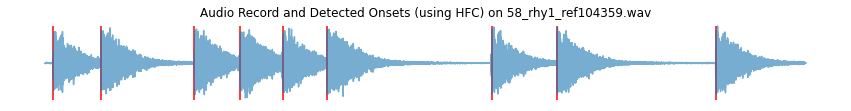

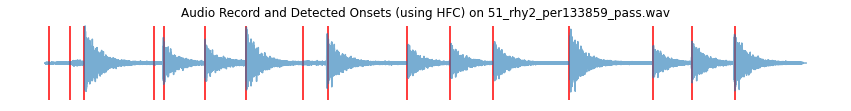

In [12]:
reference_file = '/content/data/Only References/58_rhy1_ref104359.wav' 
performance_file = '/content/data/Only Performances/51_rhy2_per133859_pass.wav'
#Plot the exampels

x_ref = _load_file_as_monophonic_waveform(reference_file)
t = np.arange(len(x_ref))/float(SAMPLE_RATE) # for plotting purposes
onsets_hfc_ref = _extract_onset_vectors(x_ref)

plt.figure(figsize=(15,1.5))
plt.plot(t ,x_ref, alpha=0.6)
plt.title("Audio Record and Detected Onsets (using HFC) on 58_rhy1_ref104359.wav");
plt.axis('off')
plt.vlines(onsets_hfc_ref, -1, 1, 'r')

plt.show()


x_per = _load_file_as_monophonic_waveform(performance_file)
t = np.arange(len(x_per))/float(SAMPLE_RATE) # for plotting purposes
onsets_hfc_per = _extract_onset_vectors(x_per)

plt.figure(figsize=(15,1.5))
plt.plot(t ,x_per, alpha=0.6)
plt.title("Audio Record and Detected Onsets (using HFC) on 51_rhy2_per133859_pass.wav");
plt.axis('off')
plt.vlines(onsets_hfc_per, -1, 1, 'r')

plt.show()



####Extracting onset detection functions

In [0]:
def get_max_length(base_dir, list_files):
    '''
    Determines the maximum length in the all records

    Parameters
    ----------
    base_dir: string
       The folder path that contains the audio files 
    
    list_files: string
       The path of the text file that contains the audio file names 
        
    Returns
    -------
    max_sample_size : integer
        maximum sample size in the all records
    '''
    performance_sample_size = []
    with open(list_files, 'r') as listfiles:
        for audio_file in listfiles.readlines():
            audio_file = audio_file.strip()
            audio_file_full_path = '%s%s' % (base_dir, audio_file)
            w = _load_file_as_monophonic_waveform(audio_file_full_path)
            performance_sample_size.append(w.size)
            max_sample_size = np.max(performance_sample_size)
    return  max_sample_size


def resample_performances(base_dir, list_files, max_sample_size):
    '''
    Resample all performances for helping alignment 

    Parameters
    ----------
    base_dir: string
       The folder path that contains the audio files 
    
    list_files: string
       The path of the text file that contains the audio file names
       
    max_sample_size : integer
        maximum sample size in the all records
        
    Returns
    -------
    writes the resampled records in base_dir folder
    '''
    with open(list_files, 'r') as listfiles:
        for audio_file in listfiles.readlines():
            audio_file = audio_file.strip()
            audio_file_full_path = '%s%s' % (base_dir, audio_file)
            w = _load_file_as_monophonic_waveform(audio_file_full_path)
            w_resample=resampy.resample(w, SAMPLE_RATE,max_sample_size/(len(w)/SAMPLE_RATE), axis=-1)
            output_file_name = '%s%s' %(base_dir, audio_file.replace(".wav", "_resample.wav"))
            with open(output_file_name, 'w') as output:
                wavio.write(output_file_name, w_resample,SAMPLE_RATE, sampwidth=2)


In [0]:
def extract_ODFs(base_dir, list_files, WINDOW_SIZE):
    
    '''
    Computation of onset detection functions 
    
    base_dir: string
       The folder path that contains the audio files 
    
    list_files: string
       The path of the text file that contains the audio file 
    
    WINDOW_SIZE : integer
       Window size to calculate spectrum of the record
      
    
    Returns
    -------
    SF_vector : numpy.array
        Contains spectral flux vectors for all records
        
    hfc_vector : numpy.array
        Contains high frequency content for all records
        
    NRG_dev_vector : numpy.array
        Contains energy deviation vector for all records       
    '''      
       
    SF_vector = []
    hfc_vector = []
    NRG_dev_vector = []
    with open(list_files, 'r') as listfiles:            
        for audio_file in listfiles.readlines():
            audio_file = audio_file.strip()
            audio_file_full_path = '%s%s' % (base_dir, audio_file.replace(".wav", "_resample.wav"))
            print(audio_file_full_path )
            w = _load_file_as_monophonic_waveform(audio_file_full_path)
            SF = spectral_flux(w, WINDOW_SIZE)
            SF_vector.append(SF)
            hfc = highFreqCont(w, WINDOW_SIZE)
            hfc_vector.append(hfc)
            NRG_dev = energy_deviation(w, WINDOW_SIZE)
            NRG_dev_vector.append(NRG_dev)
        
    return np.array(SF_vector),np.array(hfc_vector),np.array(NRG_dev_vector)

####Preprocess onset detection functions

In [0]:
def filter(x, filter_len = 5):
    '''
    Simple moving average filter for smoothing 

    Parameters
    ----------
    x : numpy.array, 
        input signal.
    filter_len : int,  
        moving average filter length. The default is 5.

    Returns
    -------
    numpy.array, filtered signal

    '''
    half_len = (filter_len - 1)//2
    filter_values = np.ones((filter_len, )) / filter_len
    return np.convolve(x, filter_values)[half_len : -half_len]

def peakLocationDetection(sig, windowSize = 5):
    '''Simple peak detection function

    Parameters
    ----------
    sig : numpy.array
        input signal.
    windowSize : int, 
        size of the window to detect the maxima and match with the center. 
        The default is 5.

    Returns
    -------
    peakIndexes : list
        indexes of the peaks in the signal.

    '''
    midPointIndex = int(windowSize / 2)
    threshold = np.max(sig) * 0.05
    peakIndexes = []
    for index in range(len(sig) - windowSize):
        frame = sig[index : index + windowSize]
        if (np.argmax(frame) == midPointIndex) and np.max(frame) > threshold:
            peakIndexes.append(index + midPointIndex)
    return peakIndexes

def preprocessODF(ODF, start_ind, stop_ind, filter_len = 5, resamp_size = 128):
    '''
    Preprocessing an onset detection function

    Parameters
    ----------
    ODF : numpy.array
        Onset detection function.
    start_ind: int
        Start index for the onset detection function, used for cropping
    stop_ind: int
        Start index for the onset detection function, used for cropping
    filter_len : int,  
        moving average filter length. The default is 5.
    resamp_size : int, 
        Target length after the resampling operation. The default is 128.

    Returns
    -------
    numpy.array
        Crooped, resampled, rescaled onset detection function.
    '''
    ODF_f = filter(ODF, filter_len = filter_len)#smoothing the ODF
    ODF_f_crop = ODF_f[start_ind : stop_ind]#cropping from first peak to last
    
    #Resampling: resampling may return one sample less in some cases, 
    # for this reason, as a quick hack, we ask for one more sample 
    # and finally get the first resamp_size samples
    ODF_f_crop_resamp = resampy.resample(ODF_f_crop, len(ODF_f_crop), resamp_size + 1, axis = -1)
    ODF_f_crop_resamp = ODF_f_crop_resamp[:resamp_size]
    
    #logarithmic compression (a small value is added to avoid log of zero)
    ODF_f_crop_resamp = ODF_f_crop_resamp - np.min(ODF_f_crop_resamp)#shift signal to positive values
    ODF_f_crop_resamp = np.log2(ODF_f_crop_resamp + np.mean(ODF_f_crop_resamp) * 0.01)
    #half wave rectification
    ODF_f_crop_resamp = ODF_f_crop_resamp - np.mean(ODF_f_crop_resamp)
    ODF_f_crop_resamp = ODF_f_crop_resamp + np.abs(ODF_f_crop_resamp)

    return  ODF_f_crop_resamp / np.max(ODF_f_crop_resamp)#amplitude normalisation

def boundary_detection(ODF, filter_len = 5):
    '''
    Detecting boundary indexes of ODF via detecting peak indexes

    Parameters
    ----------
    ODF : numpy.array
        Onset detection function.
    filter_len : int, 
        Moving avergae filter length. The default is 5.

    Returns
    -------
    int
        start index.
    int
        stop index.

    '''
    ODF_f = filter(ODF, filter_len)#smoothing the ODF
    peaks = peakLocationDetection(ODF_f)#detecting peaks from smoothed ODF
    return peaks[0], peaks[-1]


def preprocessX(X, resamp_size = 128, filter_len = 5, sizes = [516, 517, 516]):
    '''
    Preprocessing all samples of the dataset. Involves the following operations:
      - Smoothing ODF with moving average filter
      - Detection of boundary peaks and cropping
      - Resampling to a fixed size
      - Logarithmic compression
      - Amplitude normalisation

    Parameters
    ----------
    X : numpy.array 
        Dataset samples of size (n_samples, n_rows, n_columns).
    resamp_size : int, 
        Target length after the resampling operation. The default is 128.
    filter_len : int,  moving average filter length. The default is 5.

    Returns
    -------
    X_hfc_prep : numpy.array
        HFC components of the data samples (n_samples, n_rows, n_columns = resamp_size).

    '''
    X_sf = X[:, :, : sizes[0]] #spectral flux
    X_hfc = X[:, :, sizes[0] : sizes[0] + sizes[1]]#HFC available from 516 to 516+517
    X_dnrg = X[:, :, sizes[0] + sizes[1] : ]#derivative of energy
    X_prep = np.zeros((X.shape[0], 6, resamp_size))#initializing preprocessed data 
    
    for i in range(len(X)):
        #Detect boundaries of ODFs using HFC. two sets of boundaries computed: one for reference, one for performance
        start_ind_0, stop_ind_0 = boundary_detection(X_hfc[i, 0,:], filter_len = filter_len)
        start_ind_1, stop_ind_1 = boundary_detection(X_hfc[i, 1,:], filter_len = filter_len)
        #Preprocess each feature 
        X_prep[i] = np.vstack((preprocessODF(X_sf[i, 0, :],start_ind_0, stop_ind_0, filter_len = filter_len, resamp_size = resamp_size),
                               preprocessODF(X_hfc[i, 0, :],start_ind_0, stop_ind_0, filter_len = filter_len, resamp_size = resamp_size),
                               preprocessODF(X_dnrg[i, 0, :],start_ind_0, stop_ind_0, filter_len = filter_len, resamp_size = resamp_size),
                               preprocessODF(X_dnrg[i, 1, :],start_ind_1, stop_ind_1, filter_len = filter_len, resamp_size = resamp_size),
                               preprocessODF(X_hfc[i, 1, :],start_ind_1, stop_ind_1, filter_len = filter_len, resamp_size = resamp_size),
                               preprocessODF(X_sf[i, 1, :],start_ind_1, stop_ind_1, filter_len = filter_len, resamp_size = resamp_size)))
        
    return X_prep



#### Rescale all files and call extraction method for onset detection functions

In [16]:
# rescaling performances to obtain same sample size and extract the spectral flux, energy deviation and high frequency content features of each performance

resample_performances(base_dir_performances, list_files_performances, get_max_length(base_dir_performances, list_files_performances))

SF_vector_performances,hfc_vector_performances,NRG_dev_vector_performances = extract_ODFs(base_dir_performances, list_files_performances,WINDOW_SIZE)

resample_performances(base_dir_references, list_files_references, get_max_length(base_dir_references, list_files_references))
  
SF_vector_references,hfc_vector_references,NRG_dev_vector_references = extract_ODFs(base_dir_references, list_files_references,WINDOW_SIZE)

data/Only Performances/64_rhy1_per1779742_pass_resample.wav
data/Only Performances/58_rhy2_per104359_pass_resample.wav
data/Only Performances/61_rhy2_per1718752_pass_resample.wav
data/Only Performances/59_rhy1_per194959_pass_resample.wav
data/Only Performances/55_rhy1_per121260_pass_resample.wav
data/Only Performances/63_rhy2_per1176742_pass_resample.wav
data/Only Performances/52_rhy1_per181659_pass_resample.wav
data/Only Performances/58_rhy1_per180160_pass_resample.wav
data/Only Performances/55_rhy2_per197885_pass_resample.wav
data/Only Performances/55_rhy2_per138459_pass_resample.wav
data/Only Performances/53_rhy2_per147558_pass_resample.wav
data/Only Performances/59_rhy1_per131160_pass_resample.wav
data/Only Performances/52_rhy2_per121160_pass_resample.wav
data/Only Performances/59_rhy1_per124559_pass_resample.wav
data/Only Performances/55_rhy1_per152958_pass_resample.wav
data/Only Performances/52_rhy2_per147659_pass_resample.wav
data/Only Performances/66_rhy1_per1823742_pass_resamp

# **Machine Learning**

## Data preparation: feature extraction

In [0]:
preprocess = True #flag to set preprocessing on/off

####Onset detection function features with preprocessing 

In [0]:
if (preprocess == True):
  x_performances = np.concatenate((SF_vector_performances,hfc_vector_performances,NRG_dev_vector_performances),axis = 1)
  x_references = np.concatenate((SF_vector_references,hfc_vector_references,NRG_dev_vector_references),axis = 1)
  X = np.empty((80,2,1549))
  X[:,0,:] = x_performances
  X[:,1,:] = x_references
  #Preprocessing ODFs: aligning via setting boundaries to first and last peaks and resampling
  X_prep = preprocessX(X)

  X_prep = X_prep.reshape((X_prep.shape[0], X_prep.shape[1], X_prep.shape[2],-1))

  resamp_size = 128
  number_of_sample = 80
  X_SF_per = X_prep[:,0,:,:].reshape((number_of_sample,resamp_size))
  X_HFC_per = X_prep[:,1,:,:].reshape((number_of_sample,resamp_size))
  X_NRG_per = X_prep[:,2,:,:].reshape((number_of_sample,resamp_size))
  X_NRG_ref = X_prep[:,3,:,:].reshape((number_of_sample,resamp_size))
  X_HFC_ref = X_prep[:,4,:,:].reshape((number_of_sample,resamp_size))
  X_SF_ref = X_prep[:,5,:,:].reshape((number_of_sample,resamp_size))


  #Prepare the dataset to calculate distances between spectral flux, energy deviation and high frequency content vectors
  ODFs_per_vector = [X_SF_per,X_HFC_per,X_NRG_per]
  ODFs_ref_vector = [X_SF_ref,X_HFC_ref,X_NRG_ref]
  ODF_dist = []
  for i in range(0,3):
    x_performances = ODFs_per_vector[i]
    x_references = ODFs_ref_vector[i]
    ODF_dist.extend(calculate_distance_features(x_references, x_performances).T)

  ODF_dist = np.array(ODF_dist).T


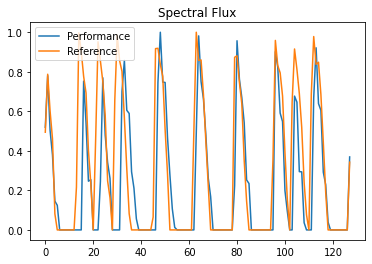

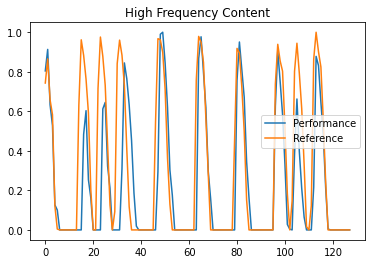

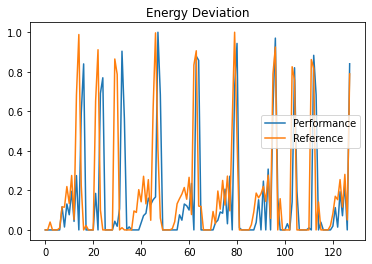

In [19]:
  #Plot sample ODFs
  k = 1
  plt.figure()
  plt.plot(X_SF_per[k],label = 'Performance')
  plt.plot(X_SF_ref[k], label = 'Reference')
  plt.title('Spectral Flux')
  plt.legend()
  plt.figure()
  plt.plot(X_HFC_per[k],label = 'Performance')
  plt.plot(X_HFC_ref[k], label = 'Reference')
  plt.title('High Frequency Content')
  plt.legend()

  plt.figure()
  plt.plot(X_NRG_per[k],label = 'Performance')
  plt.plot(X_NRG_ref[k], label = 'Reference')
  plt.title('Energy Deviation')
  plt.legend()

####Onset detection function features without preprocessing




In [0]:
if (preprocess == False):
  ODFs_per_vector = [SF_vector_performances,hfc_vector_performances,NRG_dev_vector_performances]
  ODFs_ref_vector = [SF_vector_references,hfc_vector_references,NRG_dev_vector_references]
  ODF_dist = []
  for i in range(0,3):
    x_performances = ODFs_per_vector[i]
    x_references = ODFs_ref_vector[i]
    ODF_dist.extend(calculate_distance_features(x_references, x_performances).T)

  ODF_dist = np.array(ODF_dist).T

  #Plot sample ODFs
  k = 3
  plt.figure()
  plt.plot(SF_vector_performances[k],label = 'Performance')
  plt.plot(SF_vector_references[k], label = 'Reference')
  plt.title('Spectral Flux')
  plt.legend()
  plt.figure()
  plt.plot(hfc_vector_performances[k],label = 'Performance')
  plt.plot(hfc_vector_references[k], label = 'Reference')
  plt.title('High Frequency Content')
  plt.legend()

  plt.figure()
  plt.plot(NRG_dev_vector_performances[k],label = 'Performance')
  plt.plot(NRG_dev_vector_references[k], label = 'Reference')
  plt.title('Energy Deviation')
  plt.legend()

####Extract the annotations and binary onset vectors

In [0]:
onset_dist, annotations = load_onsetDistances_labels()

#### Combine features and define the target grades

In [0]:
#Merging distances computed from onset detection function and distances computed from onsets
data = np.concatenate((ODF_dist, onset_dist),axis = 1)
#Collecting true label as average of human annotations(excluding extremes)
target = calculate_average_grade(annotations)

## Initializing machine learning models

In [0]:
#design regression methods
random_state = 7
r1 = LinearRegression()
r2 = RandomForestRegressor(random_state=random_state)
r3 = AdaBoostRegressor(random_state=random_state)
r4 = BaggingRegressor(random_state=random_state)
r5 = ExtraTreesRegressor(random_state=random_state)
er = VotingRegressor([('lr', r1), ('rf', r2), ('ab',r3),('bagging',r4),('etr',r5)]) #combine other regression models

models = []
models.append(('LR', LinearRegression()))
models.append(('RF',RandomForestRegressor(random_state=random_state)))
models.append(('Adaboost', AdaBoostRegressor(random_state=random_state)))
models.append(('Bagging', BaggingRegressor(random_state=random_state)))
models.append(('ETR',ExtraTreesRegressor(random_state=random_state)))
models.append(('VR',er))


## Training and testing of the models

In [0]:
#Split the data train and test
indices = np.arange(data.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(data, target, indices, test_size=0.2, random_state=42)

Feature normalization

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Learn scaler from train data and apply it to train and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
cv = KFold(n_splits=5, shuffle=True, random_state=42)

column_names = ['LR', 'RF', 'Adaboost','Bagging', 'ETR', 'VR','DE1','DE2']
results_on_test = pd.DataFrame(np.nan, index = ['MAE','MSE','R2'], columns = column_names)

cross_val_accuracy_mae = pd.DataFrame(index = range(0,5),columns=column_names[:-2])
cross_val_accuracy_mse = pd.DataFrame(index = range(0,5),columns=column_names[:-2])
cross_val_accuracy_r2 = pd.DataFrame(index = range(0,5),columns=column_names[:-2])
mae = []
mse = []
r2_s = []





In [27]:
for name,model in models:
    model.fit(X_train,y_train)
    cross_val_accuracy_mae[name] = abs(cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv))
    cross_val_accuracy_mse[name] = abs(cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv))
    cross_val_accuracy_r2[name] = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv)
    y_pred = model.predict(X_test)
    mae.append(mean_absolute_error(y_test,y_pred))
    mse.append(mean_squared_error(y_test,y_pred))
    r2_s.append(r2_score(y_test,y_pred))
#Generate dump estimators predictions
mae.append(mean_absolute_error(y_test, np.full_like(y_test, 2)))
mae.append(mean_absolute_error(y_test, np.full_like(y_test, 3)))
mse.append(mean_squared_error(y_test, np.full_like(y_test, 2)))
mse.append(mean_squared_error(y_test, np.full_like(y_test, 3)))
r2_s.append(r2_score(y_test, np.full_like(y_test, 2)))
r2_s.append(r2_score(y_test, np.full_like(y_test, 3)))

results_on_test.loc['MAE']=mae
results_on_test.loc['MSE']=mse
results_on_test.loc['R2']=r2_s

print('Cross-validation MAE on train data')
print(cross_val_accuracy_mae)

print('Cross-validation MSE on train data')
print(cross_val_accuracy_mse)

print('Cross-validation R2 score on train data')
print(cross_val_accuracy_r2)

print('Results on Test Set')
print(results_on_test)


Cross-validation MAE on train data
         LR        RF  Adaboost   Bagging       ETR        VR
0  0.924512  0.707385  0.863598  0.740000  0.753231  0.724983
1  0.573988  0.599538  0.504251  0.556923  0.624923  0.538810
2  0.643707  0.696308  0.782531  0.789231  0.683692  0.699800
3  0.843008  0.828462  0.875752  0.816923  0.867077  0.835383
4  1.195602  0.631333  0.622673  0.693333  0.646333  0.655849
Cross-validation MSE on train data
         LR        RF  Adaboost   Bagging       ETR        VR
0  1.250229  0.604017  0.839854  0.777754  0.671476  0.662073
1  0.418659  0.429160  0.338113  0.383631  0.498119  0.359198
2  0.519353  0.698783  0.916313  0.911292  0.676657  0.680064
3  1.061372  1.093222  1.281502  1.051231  1.189249  1.107181
4  2.089976  0.607381  0.523650  0.801933  0.634667  0.707551
Cross-validation R2 score on train data
         LR        RF  Adaboost   Bagging       ETR        VR
0 -1.034752  0.016961 -0.366866 -0.265797 -0.092830 -0.077526
1  0.370969  0.355191 

In [28]:
results_on_test.loc['MAE']

LR          0.619627
RF          0.657000
Adaboost    0.642877
Bagging     0.681250
ETR         0.584375
VR          0.572065
DE1         1.062500
DE2         0.737500
Name: MAE, dtype: float64

In [29]:
print('Average MAE of cross validation')
print(cross_val_accuracy_mae.mean())

print('Standart Deviation of Each Algoritm on Cross-Validation')
print(cross_val_accuracy_mae.std())    


print('Average MSE of cross validation')
print(cross_val_accuracy_mse.mean())

print('Standart Deviation of Each Algoritm on Cross-Validation')
print(cross_val_accuracy_mse.std())   


print('Average R2 Score of cross validation')
print(cross_val_accuracy_r2.mean())

print('Standart Deviation of Each Algoritm on Cross-Validation')
print(cross_val_accuracy_r2.std())    



Average MAE of cross validation
LR          0.836163
RF          0.692605
Adaboost    0.729761
Bagging     0.719282
ETR         0.715051
VR          0.690965
dtype: float64
Standart Deviation of Each Algoritm on Cross-Validation
LR          0.246386
RF          0.088183
Adaboost    0.161503
Bagging     0.102335
ETR         0.097977
VR          0.107791
dtype: float64
Average MSE of cross validation
LR          1.067918
RF          0.686513
Adaboost    0.779886
Bagging     0.785168
ETR         0.734034
VR          0.703213
dtype: float64
Standart Deviation of Each Algoritm on Cross-Validation
LR          0.670884
RF          0.247417
Adaboost    0.365598
Bagging     0.249131
ETR         0.264554
VR          0.266356
dtype: float64
Average R2 Score of cross validation
LR         -0.510658
RF          0.015125
Adaboost   -0.133940
Bagging    -0.148407
ETR        -0.047738
VR         -0.005386
dtype: float64
Standart Deviation of Each Algoritm on Cross-Validation
LR          0.871700
RF   

Text(0.5, 1.0, 'Algorithms performances over test set')

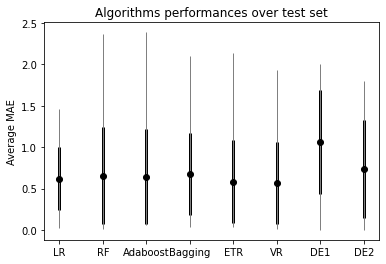

In [30]:
MAE_bar = pd.DataFrame(columns = column_names)

for name,model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    MAE_bar[name] = abs(y_test-y_pred)

MAE_bar['DE1'] = abs(y_test- np.full_like(y_test, 2))
MAE_bar['DE2'] = abs(y_test- np.full_like(y_test, 3))
means = MAE_bar.mean()
stds = MAE_bar.std()
mins = MAE_bar.min()
maxes = MAE_bar.max()
plt.errorbar(column_names, means, stds, fmt='ok', lw=3)
plt.errorbar(column_names, means, [means - mins, maxes - means],
             fmt='.k', ecolor='gray', lw=1)
plt.ylabel("Average MAE")
plt.title('Algorithms performances over test set')

## Study of feature importance

Features sorted by their score:
[(0.21, 'mean squared error (applied on onset vectors)'), (0.1, 'damerau_levenshtein (applied on onset vectors)'), (0.09, 'earth mover distance (applied on HFC)'), (0.08, 'yule (applied on onset vectors)'), (0.07, 'maximum distance (applied on SF)'), (0.05, 'earth mover distance (applied on NRG)'), (0.04, 'levenshtein (applied on onset vectors)'), (0.04, 'earth mover distance (applied on SF)'), (0.04, 'cosine similarity (applied on SF)'), (0.03, 'jaro_winkler (applied on onset vectors)'), (0.03, 'jaro (applied on onset vectors)'), (0.03, 'L1 norm (applied on NRG)'), (0.02, 'maximum distance (applied on NRG)'), (0.02, 'maximum distance (applied on HFC)'), (0.02, 'hamming (applied on onset vectors)'), (0.02, 'cosine similarity (applied on NRG)'), (0.02, 'beat_difference (applied on onset vectors)'), (0.02, 'L2 norm (applied on NRG)'), (0.02, 'L1 norm (applied on HFC)'), (0.01, 'cosine similarity (applied on HFC)'), (0.01, 'L2 norm (applied on SF)'), (0.01,

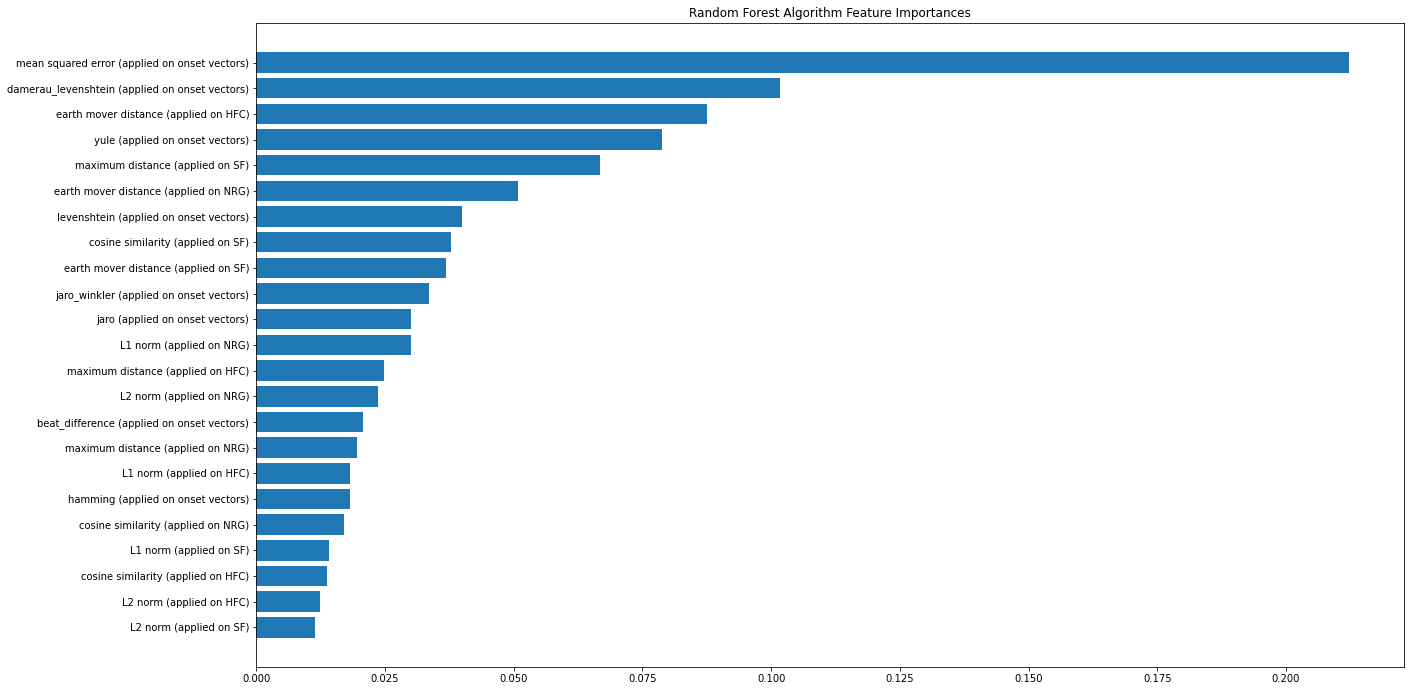

In [31]:
from numpy import sort
#Calculate the feature importances according to the Random Forest Regressor
chosed_model = r2
feature_names = ['maximum distance (applied on SF)','L1 norm (applied on SF)','L2 norm (applied on SF)','cosine similarity (applied on SF)','earth mover distance (applied on SF)','maximum distance (applied on HFC)','L1 norm (applied on HFC)','L2 norm (applied on HFC)','cosine similarity (applied on HFC)','earth mover distance (applied on HFC)','maximum distance (applied on NRG)','L1 norm (applied on NRG)','L2 norm (applied on NRG)','cosine similarity (applied on NRG)','earth mover distance (applied on NRG)',        'beat_difference (applied on onset vectors)','mean squared error (applied on onset vectors)','levenshtein (applied on onset vectors)', 'damerau_levenshtein (applied on onset vectors)', 'jaro (applied on onset vectors)', 'jaro_winkler (applied on onset vectors)', 'hamming (applied on onset vectors)', 'yule (applied on onset vectors)']
chosed_model.fit(X_train,y_train)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 2), chosed_model.feature_importances_), feature_names), 
             reverse=True))

sorted_idx = chosed_model.feature_importances_.argsort()

y_ticks = np.arange(0, len(feature_names))

sorted_feature_names = np.empty_like(feature_names)
t = 0
for i in sorted_idx:
  sorted_feature_names[t] = feature_names[i]
  t = t+1

fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(y_ticks, chosed_model.feature_importances_[sorted_idx])
ax.set_yticklabels(sorted_feature_names)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Algorithm Feature Importances")
plt.rc('font', size=20) 

fig.tight_layout()
plt.show()

In [0]:
from sklearn.feature_selection import SelectFromModel
thresholds = sort(chosed_model.feature_importances_)
k = 23
column_names = ['LR', 'RF', 'Adaboost','Bagging', 'ETR', 'VR']
thresholds_df_mae = pd.DataFrame(np.nan, index=range(0,k), columns=column_names)
thresholds_df_mse = pd.DataFrame(np.nan, index=range(0,k), columns=column_names)
thresholds_df_r2 = pd.DataFrame(np.nan, index=range(0,k), columns=column_names)

for thresh in thresholds:
    k = k-1
    selection = SelectFromModel(chosed_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # train model
    
    results_on_test_feature_imp = pd.DataFrame(np.nan,index = [0],columns = column_names)
    results_on_test_feature_imp_MSE = pd.DataFrame(np.nan,index = [0],columns = column_names)
    results_on_test_feature_imp_R2 = pd.DataFrame(np.nan,index = [0],columns = column_names)
    for name,model in models:
        model.fit(select_X_train,y_train)
        y_pred = model.predict(select_X_test)
        results_on_test_feature_imp[name] = mean_absolute_error(y_test,y_pred)
        results_on_test_feature_imp_MSE[name] = mean_squared_error(y_test,y_pred)
        results_on_test_feature_imp_R2[name] = r2_score(y_test,y_pred)
        thresholds_df_mae.loc[k] = np.array(results_on_test_feature_imp)
        thresholds_df_mse.loc[k] = np.array(results_on_test_feature_imp_MSE)
        thresholds_df_r2.loc[k] = np.array(results_on_test_feature_imp_R2)



    


Text(0, 0.5, 'MAE')

<Figure size 1440x720 with 0 Axes>

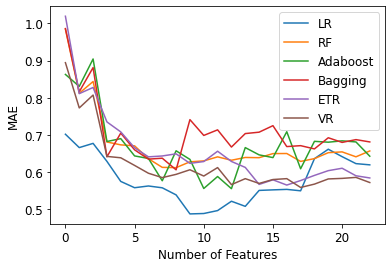

In [33]:
plt.figure(figsize=(20,10))
plt.rc('font',size=12)

thresholds_df_mae.plot.line()
plt.xlabel('Number of Features')
plt.ylabel('MAE')



# **Analysis of human annotation consistency**

<Figure size 432x288 with 0 Axes>

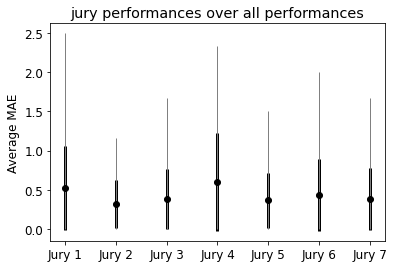

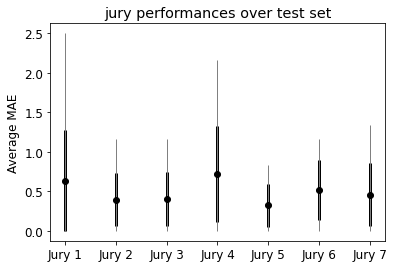

<Figure size 432x288 with 0 Axes>

In [35]:
def calculate_performance_of_jury_member(annotations,target):
    
    cols = ['Jury 1','Jury 2','Jury 3','Jury 4','Jury 5','Jury 6','Jury 7']
    jury_performance = pd.DataFrame(columns = cols)
    for i in range(0,7):
        col_name = 'Jury %i' % (i+1) 
        one_out_target = (annotations.sum(axis=1)-annotations[:,i])/6
        jury_performance[col_name] =abs(annotations[:,i]-one_out_target)
        
    return jury_performance

plt.figure()
cols = ['Jury 1','Jury 2','Jury 3','Jury 4','Jury 5','Jury 6','Jury 7']
#jury performances over all performances
jury_performance = calculate_performance_of_jury_member(annotations,target)
means = jury_performance.mean()
stds = jury_performance.std()
mins = jury_performance.min()
maxes = jury_performance.max()
plt.errorbar(cols, means, stds, fmt='ok', lw=3)
plt.errorbar(cols, means, [means - mins, maxes - means],
             fmt='.k', ecolor='gray', lw=1)
plt.ylabel("Average MAE")


plt.title('jury performances over all performances')

plt.figure()
#jury performances over test performances
jury_performance = calculate_performance_of_jury_member(annotations[idx_test],target[idx_test])
means = jury_performance.mean()
stds = jury_performance.std()
mins = jury_performance.min()
maxes = jury_performance.max()
plt.errorbar(cols, means, stds, fmt='ok', lw=3)
plt.errorbar(cols, means, [means - mins, maxes - means],
             fmt='.k', ecolor='gray', lw=1)
plt.ylabel("Average MAE")
plt.title('jury performances over test set')

plt.figure()

In [36]:
print('Average MAE error of jury members over test set')
print(jury_performance.sum(axis=0)/len(y_test))

Average MAE error of jury members over test set
Jury 1    0.635417
Jury 2    0.395833
Jury 3    0.406250
Jury 4    0.718750
Jury 5    0.322917
Jury 6    0.520833
Jury 7    0.458333
dtype: float64
